# Modelos de regresión

In [1]:
!pip install gpboost
!pip install shap
!pip install xgboost
!pip install geopandas

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt
import contextily

# Modelos
import gpboost as gpb
import shap
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


## Lectura de datos 

In [122]:
data = pd.read_csv('./data/modelling_data.csv',  index_col=[0])

In [123]:
data.head()

,id,antig,m2total,m2cub,ambientes,banios,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,...,monoambiente,poi_count_gastronomia,poi_count_educacion,poi_count_roads,poi_count_salud,poi_count_transporte,cardinality,SonCosteros,clusters,geometry
0,1,0,200,200,0.0,0,1500000,7500.000000,1162.621600,14053.797191,...,1,52.0,16.0,7.0,6.0,2.0,8,0.0,0,POINT (-6515379.180859259 -4114970.853546773)
1,2,30,50,50,0.0,1,125000,2500.000000,1887.227055,13473.139375,...,1,6.0,0.0,10.0,1.0,0.0,1,0.0,-1,POINT (-6515322.519238445 -4111251.604641595)
2,3,30,414,414,0.0,2,590000,1425.120773,1497.020434,13514.662463,...,1,4.0,3.0,9.0,2.0,0.0,6,0.0,-1,POINT (-6515319.513612195 -4111882.057282486)
3,4,35,414,414,0.0,2,730000,1763.000000,1506.066814,13495.631683,...,1,7.0,3.0,10.0,2.0,0.0,5,0.0,-1,POINT (-6515298.028950469 -4111865.284430326)
4,5,35,285,285,0.0,1,550000,1929.000000,1506.066814,13495.631683,...,1,7.0,3.0,10.0,2.0,0.0,5,0.0,-1,POINT (-6515298.028950469 -4111865.284430326)


In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3670 entries, 0 to 3669
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3670 non-null   int64  
 1   antig                  3670 non-null   int64  
 2   m2total                3670 non-null   int64  
 3   m2cub                  3670 non-null   int64  
 4   ambientes              3629 non-null   float64
 5   banios                 3670 non-null   int64  
 6   precioUSD              3670 non-null   int64  
 7   m2precioUSD            3670 non-null   float64
 8   comisaria_dista        3670 non-null   float64
 9   obelisco_dista         3670 non-null   float64
 10  nrobos                 3670 non-null   int64  
 11  sup_espacio_verde      3670 non-null   float64
 12  count_gastronomia      3670 non-null   int64  
 13  lon_planar             3670 non-null   float64
 14  lat_planar             3670 non-null   float64
 15  comu

In [125]:
data['geometry'] = data['geometry'].apply(wkt.loads)
geo_data = gpd.GeoDataFrame(data, crs='epsg:3857').to_crs(epsg=4326)

In [126]:
y = data.precioUSD
y_log = np.log(data.precioUSD)
X = data.drop(["precioUSD", "id", "m2precioUSD", "lon_planar", "lat_planar", "count_gastronomia", "densidad_viviendas"], axis = 1)

In [127]:
X.head()

,antig,m2total,m2cub,ambientes,banios,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,comunas,...,monoambiente,poi_count_gastronomia,poi_count_educacion,poi_count_roads,poi_count_salud,poi_count_transporte,cardinality,SonCosteros,clusters,geometry
0,0,200,200,0.0,0,1162.621600,14053.797191,134,68426.445,9,...,1,52.0,16.0,7.0,6.0,2.0,8,0.0,0,POINT (-6515379.181 -4114970.854)
1,30,50,50,0.0,1,1887.227055,13473.139375,23,110997.543,11,...,1,6.0,0.0,10.0,1.0,0.0,1,0.0,-1,POINT (-6515322.519 -4111251.605)
2,30,414,414,0.0,2,1497.020434,13514.662463,33,115341.039,10,...,1,4.0,3.0,9.0,2.0,0.0,6,0.0,-1,POINT (-6515319.514 -4111882.057)
3,35,414,414,0.0,2,1506.066814,13495.631683,33,115500.289,10,...,1,7.0,3.0,10.0,2.0,0.0,5,0.0,-1,POINT (-6515298.029 -4111865.284)
4,35,285,285,0.0,1,1506.066814,13495.631683,33,115500.289,10,...,1,7.0,3.0,10.0,2.0,0.0,5,0.0,-1,POINT (-6515298.029 -4111865.284)


In [128]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3670 entries, 0 to 3669
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   antig                  3670 non-null   int64   
 1   m2total                3670 non-null   int64   
 2   m2cub                  3670 non-null   int64   
 3   ambientes              3629 non-null   float64 
 4   banios                 3670 non-null   int64   
 5   comisaria_dista        3670 non-null   float64 
 6   obelisco_dista         3670 non-null   float64 
 7   nrobos                 3670 non-null   int64   
 8   sup_espacio_verde      3670 non-null   float64 
 9   comunas                3670 non-null   int64   
 10  barrios                3670 non-null   object  
 11  densidad_poblacional   3670 non-null   float64 
 12  distritos              3670 non-null   object  
 13  SobreAvenida           3670 non-null   int64   
 14  Aestrenar              3670 non-null   i

## Modelo de regresión

In [137]:
variable_names = [
    'antig',    
    'm2total',   
    'm2cub',     
    #'ambientes', 
    'banios',
    'comisaria_dista',
    'obelisco_dista',
    'nrobos',
    'sup_espacio_verde',
    'poi_count_gastronomia',
    'poi_count_educacion',
    'poi_count_roads',
    'poi_count_salud',
    'poi_count_transporte',
    'cardinality',
    'clusters',
    # Variables binarias
    'SobreAvenida',
    'Aestrenar',
    'monoambiente',
    'SonCosteros'
]

In [138]:
from pysal.model import spreg

X[variable_names]In the context of this chapter, it makes sense to start with `PySAL` as that is the only library that will allow us to move into explicitly spatial econometric models. To fit the model specified in the equation above with $X$ as the list defined, we only need the following line of code:

In [141]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y_log.values, 
    # Independent variables
    X[variable_names].values,
    # Dependent variable name
    name_y='log_price', 
    # Independent variable name
    name_x=variable_names
)

In [142]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        3670
Mean dependent var  :     12.4399                Number of Variables   :          20
S.D. dependent var  :      0.9390                Degrees of Freedom    :        3650
R-squared           :      0.5633
Adjusted R-squared  :      0.5610
Sum squared residual:    1412.764                F-statistic           :    247.7685
Sigma-square        :       0.387                Prob(F-statistic)     :           0
S.E. of regression  :       0.622                Log likelihood        :   -3455.733
Sigma-square ML     :       0.385                Akaike info criterion :    6951.467
S.E of regression ML:      0.6204                Schwarz criterion     :    7075.626

-----------------------------------------------------------------------------

In [143]:
evaluacion_regresion = data.copy()

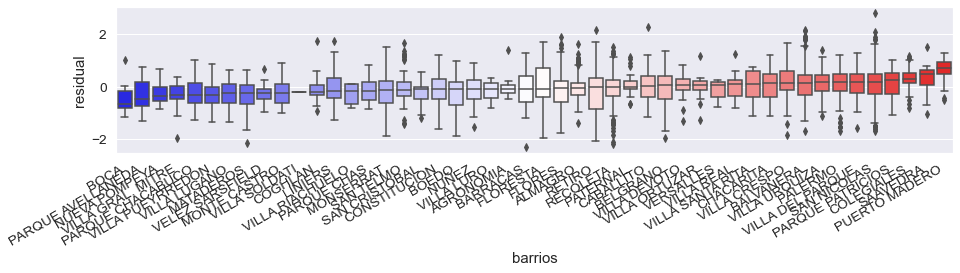

In [144]:
# Create column with residual values from m1
evaluacion_regresion['residual'] = m1.u
# Obtain the median value of residuals in each neighbourhood
medians = evaluacion_regresion.groupby(
    "barrios"
).residual.median().to_frame(
    'hood_residual'
)

# Increase fontsize
sns.set(font_scale = 1.25)
# Set up figure
f = plt.figure(figsize=(15,3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighbourhood
# Note the data includes the median values merged on-the-fly
sns.boxplot(
    'barrios', 
    'residual', 
    ax = ax,
    data=evaluacion_regresion.merge(
        medians, 
        how='left',
        left_on='barrios',
        right_index=True
    ).sort_values(
        'hood_residual'), palette='bwr'
)
# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

In [145]:
from pysal.lib import weights
from pysal.explore import esda

In [146]:
# Calcular matriz de pesos espaciales
w = weights.KNN.from_dataframe(geo_data, k = 20)

This means that, when we compute the *spatial lag* of that $KNN$ weight and the residual, we get the residual of the AirBnB listing closest to each observation.

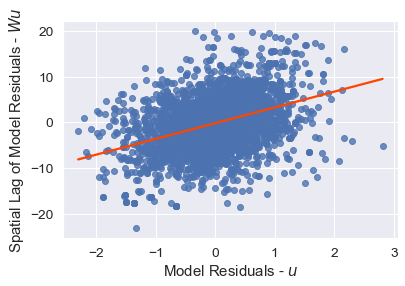

In [147]:
lag_residual = weights.spatial_lag.lag_spatial(w, m1.u)
ax = sns.regplot(
    m1.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

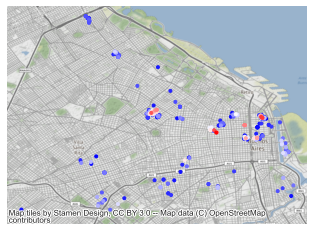

In [148]:
# Row-standardization
w.transform = 'R'
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, w, permutations=9999)
# Select only LISA cluster cores
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .001)
# Add `error_clusters` and `local_I` columns
ax = geo_data.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
# Retain error clusters only
).query(
    "error_clusters"
# Sort by I value to largest plot on top
).sort_values(
    'local_I'
# Plot I values
).plot(
    'local_I', cmap='bwr', marker='.'
)
# Add basemap
contextily.add_basemap(ax, crs=geo_data.crs)
# Remove axes
ax.set_axis_off();

In [149]:
# Set up table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m1.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m1.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m1.t_stat]
    },
    index=m1.name_x
)

,Coeff.,Std. Error,P-Value
CONSTANT,1.191945e+01,8.217680e-02,0.000000e+00
antig,-6.114301e-03,8.757317e-04,3.443706e-12
m2total,3.544324e-03,1.680540e-04,2.889319e-93
m2cub,6.071008e-04,1.780750e-04,6.585005e-04
banios,4.771896e-02,8.660932e-03,3.843435e-08
comisaria_dista,-3.329375e-05,3.252089e-05,3.060141e-01
obelisco_dista,-2.301521e-05,4.933840e-06,3.200444e-06
nrobos,-1.031378e-03,2.602780e-04,7.555503e-05
sup_espacio_verde,1.862059e-07,1.410038e-07,1.867264e-01
poi_count_gastronomia,3.160953e-03,4.986108e-04,2.586340e-10


In [150]:
import statsmodels.formula.api as sm

This package provides a formula-like API, which allows us to express the *equation* we wish to estimate directly:

In [151]:
f = 'precioUSD ~ ' + ' + '.join(variable_names) + ' + barrios - 1'
print(f)

precioUSD ~ antig + m2total + m2cub + banios + comisaria_dista + obelisco_dista + nrobos + sup_espacio_verde + poi_count_gastronomia + poi_count_educacion + poi_count_roads + poi_count_salud + poi_count_transporte + cardinality + clusters + SobreAvenida + Aestrenar + monoambiente + SonCosteros + barrios - 1


The *tilde* operator in this statement is usually read as "log price is a function of ...", to account for the fact that many different model specifications can be fit according to that functional relationship between `log_price` and our covariate list. Critically, note that the trailing `-1` term means that we are fitting this model without an intercept term. This is necessary, since including an intercept term alongside unique means for every neighborhood would make the underlying system of equations underspecified.  

Using this expression, we can estimate the unique effects of each neighborhood, fitting the model in `statsmodels` (note how the specification of the model, formula and data, is separated from the fitting step): 

In [152]:
m2 = sm.ols(f, data=data).fit()

We could rely on the `summary2()` method to print a similar summary report from the regression but, given it is a lengthy one in this case, we will illustrate how you can extract the spatial fixed effects into a table for display.

In [153]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m2.params.index if 'barrios[' in i]
# Create table
pd.DataFrame(
    {
        'Coef.': m2.params[sfe_names],
        'Std. Error': m2.bse[sfe_names],
        'P-Value': m2.pvalues[sfe_names]
    }
)

,Coef.,Std. Error,P-Value
barrios[AGRONOMIA],20032.479958,141129.139361,8.871319e-01
barrios[ALMAGRO],95389.905420,63971.775467,1.360162e-01
barrios[BALVANERA],138439.855588,56236.136224,1.387223e-02
barrios[BARRACAS],20355.280544,69874.173775,7.708284e-01
barrios[BELGRANO],-90877.760510,52479.502305,8.341593e-02
barrios[BOCA],58764.792607,84654.936095,4.876213e-01
barrios[BOEDO],-40839.281586,74657.677002,5.843985e-01
barrios[CABALLITO],66428.648278,77788.291853,3.931799e-01
barrios[CHACARITA],51416.339524,87247.980262,5.556885e-01
barrios[COGHLAN],47552.827879,126093.640704,7.061043e-01


The approach above shows how spatial FE are a particular case of a linear regression with a categorical  variable. Neighborhood membership is modeled using binary dummy variables. Thanks to the formula grammar used in `statsmodels`, we can express the model abstractly, and Python parses it, appropriately creating binary variables as required.

The second approach leverages `PySAL` Regimes functionality. We will see regimes below but, for now, think of them as a generalisation of spatial fixed effects where not only $\alpha$ can vary. This framework allows the user to specify which variables are to be estimated separately for each group. In this case, instead of describing the model in a formula, we need to pass each element of the model as separate arguments.

In [154]:
# PySAL spatial fixed effect implementation
m3 = spreg.OLS_Regimes(
    # Dependent variable
    y.values, 
    # Independent variables
    X[variable_names].values,
    # Variable specifying neighborhood membership
    X['barrios'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False]*len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    #regime_err_sep=False, # Da error. Tengo que averiguar el motivo. Falla el cálculo
    # Dependent variable name
    name_y='precioUSD', 
    # Independent variables names
    name_x=variable_names
)

Econometrically speaking, what the neighborhood FEs we have introduced imply is that, instead of comparing all house prices across San Diego as equal, we only derive variation from within each postcode. Remember that the interpretation of $\beta_k$ is the effect of variable $k$, *given all the other explanatory variables included remain constant*. By including a single variable for each area, we are effectively forcing the model to compare as equal only house prices that share the same value for each variable; or, in other words, only houses located within the same area. Introducing FE affords a higher degree of isolation of the effects of the variables we introduce in the model because we can control for unobserved effects that align spatially with the distribution of the FE introduced (by neighborhood, in our case). To make a map of neighborhood fixed effects, we need to process the results from our model slightly.

First, we extract only the effects pertaining to the neighborhoods:

In [155]:
neighborhood_effects = m2.params.filter(like='barrios')
neighborhood_effects.head()

barrios[AGRONOMIA]     20032.479958
barrios[ALMAGRO]       95389.905420
barrios[BALVANERA]    138439.855588
barrios[BARRACAS]      20355.280544
barrios[BELGRANO]     -90877.760510
dtype: float64

Then, we need to extract just the neighborhood name from the index of this Series. A simple way to do this is to strip all the characters that come before and after our neighborhood names:

In [156]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    'barrios['
).str.strip(']')
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
# Print top of table
neighborhood_effects.head()

,fixed_effect
AGRONOMIA,20032.479958
ALMAGRO,95389.905420
BALVANERA,138439.855588
BARRACAS,20355.280544
BELGRANO,-90877.760510


Good, we're back to our raw neighborhood names. These allow us to join it to an auxillary file with neighborhood boundaries that is indexed on the same names. Let's read the boundaries first:

In [157]:
# Descargar geojson de la base de datos del gobierno de CABA
url = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson"
barrios = gpd.read_file(url).to_crs(epsg=3857)
# Elegir las columnas de interes
barrios = barrios[["BARRIO", "geometry"]]
# Corregir nombres de variables
barrios = barrios.rename(columns = {"BARRIO" : "barrios"})

And we can then merge the spatial fixed effects and plot them on a map:

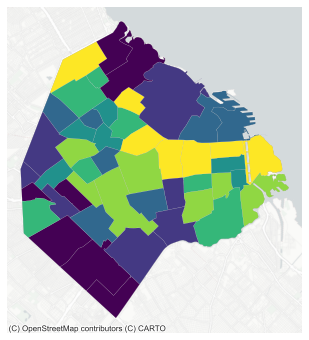

In [158]:
# Plot base layer with all neighborhoods in grey
ax = barrios.plot(
    color='k', linewidth=0, alpha=0.5, figsize=(12,6)
)
# Merge SFE estimates (note not every polygon
# receives an estimate since not every polygon
# contains AirBnb properties)
barrios.merge(
    neighborhood_effects, 
    how='left',
    left_on='barrios', 
    right_index=True
# Drop polygons without a SFE estimate
).dropna(
    subset=['fixed_effect']
# Plot quantile choropleth
).plot(
    'fixed_effect',     # Variable to display
    scheme='quantiles', # Choropleth scheme
    k=7,                # No. of classes in the choropleth
    linewidth=0.1,      # Polygon border width
    cmap='viridis',     # Color scheme
    ax=ax               # Axis to draw on
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=barrios.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.33, random_state=42)

coords_train = X_train[['lon_planar', 'lat_planar']]
coords_test = X_test[['lon_planar', 'lat_planar']]

In [8]:
drop_features = ['id', 'lon_planar', 'lat_planar', 'comunas']

In [9]:
X_train = X_train.drop(features, axis = 1)
X_test = X_test.drop(features, axis = 1)

NameError: name 'X_train' is not defined

In [18]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

## Aplicamos la transformación de escala sobre los features
scaler_X.fit(X_train)
X_scaled_train = scaler_X.transform(X_train)
X_scaled_test  = scaler_X.transform(X_test)

## Aplicamos la transformación de escala sobre la variable objetivo
## Observación: StandardScaler toma como input una matriz. Si queremos darle un
## vector (como por ej. para utilizar con la variable objetivo), tenemos que 
## transformar ese vector en una matriz de una sola columna. Esto lo hacemos
## con el método 'reshape'
scaler_y.fit(y_train.values.reshape(-1, 1))
y_scaled_train = scaler_y.transform(y_train.values.reshape(-1, 1))[:,0]
y_scaled_test  = scaler_y.transform(y_test.values.reshape(-1, 1))[:,0]

In [19]:
gp_model = gpb.GPModel(gp_coords = coords_train, cov_function="exponential")
data_train = gpb.Dataset(X_train, y_train)
params = { 'objective': 'regression_l2', 'verbose': 0 }
# Training
bst = gpb.train(params=params, train_set=data_train,
                gp_model=gp_model, num_boost_round=247)
gp_model.summary() # Estimated covariance parameters
# Prediction
pred = bst.predict(data=X_test, gp_coords_pred=coords_test,
                    predict_var=True)
# Sum the predictions of the trees and the GP
y_pred = pred['fixed_effect'] + pred['random_effect_mean']

[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
Covariance parameters 
['Error_term', 'GP_var', 'GP_range']
[1.96807923e+10 1.90227881e+11 2.71014487e+01]


In [20]:
## Utilizaremos la raiz cuadrada del error cuadrático medio como 
## medida del error
def rmse(y1, y2):
    """
    Raiz cuadrada del error cuadrático medio.
    """
    return np.sqrt(mean_squared_error(y1, y2))

In [21]:
from sklearn.metrics import mean_squared_error

In [23]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_test  = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

In [24]:
rmse(y_test, pred_test)

211845016809.0451

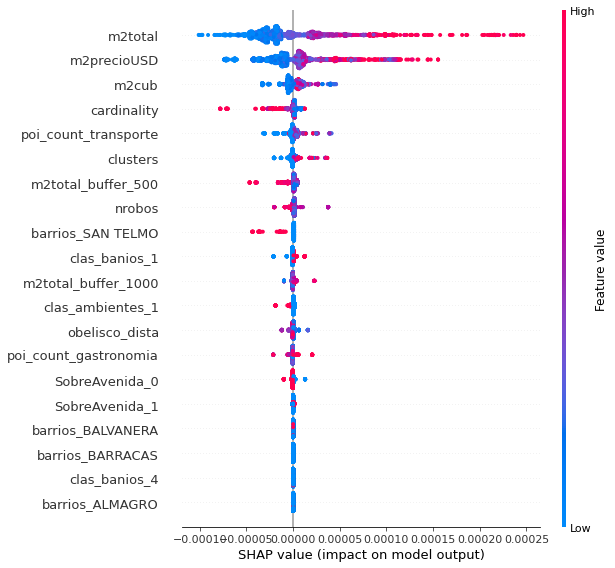

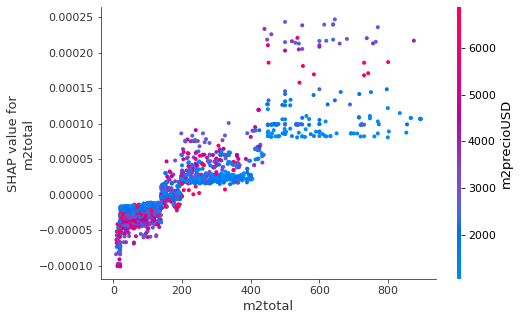

In [25]:
shap_values = shap.TreeExplainer(bst).shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.dependence_plot("m2total", shap_values, X_train)

In [ ]:
# --------------------Parameter tuning using a validation set----------------
# Define training and validation data by setting indices of 'folds'
n = len(X_train_
permut = np.random.RandomState(10).choice(a=n, size=n, replace=False)
train_idx = permut[0:int(n/2)]
valid_idx = permut[int(n/2):n]
folds = [(train_idx, valid_idx)]
# Parameter tuning using validation data
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid_small,
                                             params=params,
                                             folds=folds,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=1,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             seed=1000,
                                             metrics='binary_logloss')
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

## XGBoost

In [27]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [28]:
# import packages for hyperparameters tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error
import time

In [29]:
# Definicion de la funcion de pérdida del RMSE
def RMSLE(y, y_pred):
    """ 
    Función de costo del rmse
    """
    return (np.sqrt(mean_squared_error(y, y_pred)))

# Definicion del scoring para usar en la validación
rmsle_loss = make_scorer(RMSLE, greater_is_better=False)

In [30]:
param_grid={"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "min_child_weight" : [ 1, 3, 5, 7 ],
             "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

model = xg.XGBRegressor()


In [33]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring=rmsle_loss, cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 0, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer).reshape(-1, 1))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer).reshape(-1, 1))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer.reshape(-1, 1))
    test_rescaled  = scaler_y.inverse_transform(y_test_outer.reshape(-1, 1))
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

[20:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=47549.432, RMSE_test=69666.861 score = -0.266, param = {'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.7}
La iteración tomó 244.977 segundos.
[20:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=38348.635, RMSE_test=134892.554 score = -0.249, param = {'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 0.7}
La iteración tomó 224.458 segundos.
[20:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=59685.454, RMSE_test=104860.885 score = -0.275, param = {'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
La iteración tomó 256.906 segundos.
[20:

In [34]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

[20:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.15,
             min_child_weight=5)

In [36]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train).reshape(-1, 1))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test).reshape(-1, 1))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Train RMSE: 49842.99208953134
Test RMSE: 144095.33213447925


## Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor()


In [ ]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=10, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring=rmsle_loss, cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 0, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer).reshape(-1, 1))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer).reshape(-1, 1))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer.reshape(-1, 1))
    test_rescaled  = scaler_y.inverse_transform(y_test_outer.reshape(-1, 1))
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [ ]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

In [ ]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train).reshape(-1, 1))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test).reshape(-1, 1))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Feature importance

In [ ]:
train_features = list(X_train.columns)

In [ ]:
base_imp = imp_df(train_features, best_model.feature_importances_)
base_imp

In [ ]:
var_imp_plot(base_imp, 'Importancia de cada feature')